# Quantify circular RNA level edit rate
- show for each circular RNA
    - overall edit rate
    - edit rate per base
    
    - edit rate is higher than null (HEK293_rar11)
    - edit rate is different by protein (IGF2BP2, U2AF1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
f='/home/hsher/scratch/circ_nextera_iter13/output/edits/APOBEC1only.dp4.neg.vcf.non_zero.tsv'
alt = 'A'
neg = pd.read_csv(f, sep = '\t', 
                  names = ['CHROM','POS','REF', 'ALT','FILTER','TYPE','DP','AD','ADF','ADR'])
neg = neg.loc[neg['ALT'].str.contains(alt)]

In [3]:
neg['n_REF']=neg['AD'].apply(lambda s: int(s.split(',')[0]))
neg['n_ALT']=neg['AD'].apply(lambda s: int(s.split(',')[1]))

In [4]:
from scipy.special import betainc
def process(num_reads, n_edited, alfa=0, beta=0, cov_margin=0.01, keep_all_edited=True):
    """
    Calculates, for a single line in a VCF formatted file, the
    confidence score based on depth of coverage and edit fraction %.

    :param line: string
        single vcf formatted line.
    :return confidence: float
        confidence value of the line
    :return return_string: basestring
        full vcf formatted line with confidence
    """
    
    edit_frac = n_edited / float(num_reads)

    # calc smoothed counts and confidence
    destination_smoothed = n_edited + alfa
    origin_smoothed = (num_reads-n_edited) + beta
    theta = destination_smoothed / float(destination_smoothed + origin_smoothed)

    ########  MOST IMPORTANT LINE  ########
    # calculates the confidence of theta as
    # P( theta < cov_margin | A, G) ~ Beta_theta(G, A)
    confidence = 1 - betainc(destination_smoothed, origin_smoothed, cov_margin)
    
    

    # print line in CONF format
#     return_string = ("\t".join([chr, pos, str(num_reads), ref, alt, ""]) +
#                      "\t".join(str(round(y, 9)) for y in [
#                          confidence, theta, edit_frac
#                      ]) +
#                      "\t".join(["", region, info, format, cond]) +
#                      "\n")
    return edit_frac, theta, confidence

In [5]:
cov_margin = 0.05
ref = 'C'
dest = 'T'
from statsmodels.stats.multitest import fdrcorrection

def call_edits(all_counts, cov_margin=0.05, ref=ref, dest=dest):
    for index, row in all_counts.iterrows():
        edit_frac, theta, confidence = process(row['n_REF']+row['n_ALT'], row['n_ALT'], cov_margin = cov_margin)
        all_counts.loc[index, 'edit_frac'] = edit_frac
        all_counts.loc[index, 'theta'] = theta
        all_counts.loc[index, 'confidence'] = confidence
        all_counts['confidence'] = all_counts['confidence'].fillna(0)
        all_counts['pvalue']=1-all_counts['confidence']
    
    return all_counts

In [6]:
unique_counts = neg[['n_REF', 'n_ALT']].drop_duplicates().copy()
unique_counts = call_edits(unique_counts)

In [7]:
unique_counts

,n_REF,n_ALT,edit_frac,theta,confidence,pvalue
0,27,2,0.068966,0.068966,0.588309,4.116914e-01
1,43,2,0.044444,0.044444,0.347077,6.529232e-01
2,36,1,0.027027,0.027027,0.157779,8.422208e-01
3,31,1,0.031250,0.031250,0.203907,7.960932e-01
4,33,1,0.029412,0.029412,0.184026,8.159741e-01
...,...,...,...,...,...,...
271124,147,9,0.057692,0.057692,0.628332,3.716677e-01
271301,123,24,0.163265,0.163265,1.000000,2.931012e-07
272075,6,36,0.857143,0.857143,1.000000,0.000000e+00
272432,63,12,0.160000,0.160000,0.999705,2.948230e-04


In [8]:
neg = neg.merge(unique_counts, left_on = ['n_REF', 'n_ALT'],right_on = ['n_REF', 'n_ALT'])
_,neg['FDR'] = fdrcorrection(neg['pvalue'])

In [9]:
neg

,CHROM,POS,REF,ALT,FILTER,TYPE,DP,AD,ADF,ADR,n_REF,n_ALT,edit_frac,theta,confidence,pvalue,FDR
0,GL000195.1:48955|79328,63,G,"A,<*>",PASS,MIXED,31,"27,2,0","27,2,0","0,0,0",27,2,0.068966,0.068966,0.588309,4.116914e-01,0.999999
1,chr1:211952569|211982810,45616,G,"A,<*>",PASS,MIXED,31,"27,2,0","12,1,0","15,1,0",27,2,0.068966,0.068966,0.588309,4.116914e-01,0.999999
2,chr1:176081152|176136547,4691,G,"A,<*>",PASS,MIXED,30,"27,2,0","19,0,0","8,2,0",27,2,0.068966,0.068966,0.588309,4.116914e-01,0.999999
3,chr1:226277775|226287797,9916,G,"A,<*>",PASS,MIXED,29,"27,2,0","23,2,0","4,0,0",27,2,0.068966,0.068966,0.588309,4.116914e-01,0.999999
4,chr1:114732604|114749904,4236,G,"A,<*>",PASS,MIXED,30,"27,2,0","25,2,0","2,0,0",27,2,0.068966,0.068966,0.588309,4.116914e-01,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251542,chrX:72272640|72276234,128,G,"A,<*>",PASS,MIXED,164,"147,9,0","132,5,0","15,4,0",147,9,0.057692,0.057692,0.628332,3.716677e-01,0.999999
251543,chrX:44524002|44527326,270,G,"A,<*>",PASS,MIXED,151,"123,24,0","87,13,0","36,11,0",123,24,0.163265,0.163265,1.000000,2.931012e-07,0.000056
251544,chrX:40712914|40715220,992,G,"A,<*>",PASS,MIXED,42,"6,36,0","0,14,0","6,22,0",6,36,0.857143,0.857143,1.000000,0.000000e+00,0.000000
251545,chrX:53645311|53680694,35530,G,"A,<*>",PASS,MIXED,80,"63,12,0","28,7,0","35,5,0",63,12,0.160000,0.160000,0.999705,2.948230e-04,0.025199


<AxesSubplot:>

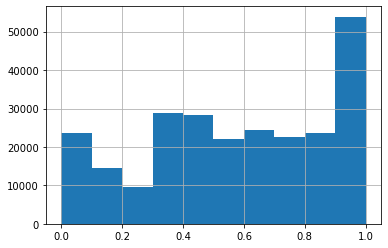

In [10]:
neg['pvalue'].hist()

In [11]:
neg.loc[neg['pvalue']<0.01]

,CHROM,POS,REF,ALT,FILTER,TYPE,DP,AD,ADF,ADR,n_REF,n_ALT,edit_frac,theta,confidence,pvalue,FDR
9581,GL000195.1:48955|79328,5864,G,"A,<*>",PASS,MIXED,14,"2,10,0","2,8,0","0,2,0",2,10,0.833333,0.833333,1.000000,1.025402e-12,3.434578e-10
9582,chr1:70175810|70184914,9035,G,"A,<*>",PASS,MIXED,22,"2,10,0","2,10,0","0,0,0",2,10,0.833333,0.833333,1.000000,1.025402e-12,3.434578e-10
9583,chr1:16484823|16631109,89242,G,"A,<*>",PASS,MIXED,12,"2,10,0","2,8,0","0,2,0",2,10,0.833333,0.833333,1.000000,1.025402e-12,3.434578e-10
9584,chr1:145291789|145370116,115533,G,"A,<*>",PASS,MIXED,14,"2,10,0","1,3,0","1,7,0",2,10,0.833333,0.833333,1.000000,1.025402e-12,3.434578e-10
9585,chr10:63167146|63177856,822,G,"A,<*>",PASS,MIXED,12,"2,10,0","2,8,0","0,2,0",2,10,0.833333,0.833333,1.000000,1.025402e-12,3.434578e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251541,chrX:14850505|14859334,8809,G,"A,<*>",PASS,MIXED,248,"152,41,0","85,28,0","67,13,0",152,41,0.212435,0.212435,1.000000,2.997602e-15,1.309093e-12
251543,chrX:44524002|44527326,270,G,"A,<*>",PASS,MIXED,151,"123,24,0","87,13,0","36,11,0",123,24,0.163265,0.163265,1.000000,2.931012e-07,5.649710e-05
251544,chrX:40712914|40715220,992,G,"A,<*>",PASS,MIXED,42,"6,36,0","0,14,0","6,22,0",6,36,0.857143,0.857143,1.000000,0.000000e+00,0.000000e+00
251545,chrX:53645311|53680694,35530,G,"A,<*>",PASS,MIXED,80,"63,12,0","28,7,0","35,5,0",63,12,0.160000,0.160000,0.999705,2.948230e-04,2.519940e-02
